# 6/28 + 7/1: Bayesian regression with pymc3

In [1]:
#import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import scipy.stats as stats
import pymc3 as pm

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# Function Definition

In [2]:
#Functions
    #get_data()
    #summary_stats(period = 'M', state = 'CA', reporting_area1, reporting_area2)
    #stats_df(summary)
    #pm_reporting_area1(df, n_success_prior = 15, n_failure_prior = 15)
    #pm_reporting_area2(df, n_success_prior = 15, n_failure_prior = 15)


In [5]:
### Function to load + clean data

def get_data():
    #print('test')
    data = pd.read_csv('../Data/data.csv')
    #print(data.shape)
    data.drop(['Unnamed: 0'], axis=1, inplace = True)
    data['valid date'] = pd.to_datetime(data['valid date'])
    #print(data['valid date'].dtype)
    data['categorical'] = [1 if (cat == 'Good' or cat == 'Moderate') else 0 for cat in data['AQI category']]
    data = data[data['state code'].isnull() == False]
    return(data)


In [6]:
data = get_data()
data.head()

,issue date,valid date,valid time,time zone,record sequence,data type,primary,reporting area,state code,latitude,longitude,pollutant,AQI value,AQI category,action day,discussion,forecast source,urldate,categorical
0,06/01/17,2017-05-31,NaN,PDT,-1.0,Y,Y,Aberdeen,WA,46.9725,-123.8317,PM2.5,11.0,Good,No,NaN,Olympic Region Clean Air Agency,20170601,1
1,06/01/17,2017-06-01,21:00,PDT,0.0,O,Y,Aberdeen,WA,46.9725,-123.8317,PM2.5,10.0,Good,No,NaN,Olympic Region Clean Air Agency,20170601,1
2,05/31/17,2017-06-01,NaN,EDT,1.0,F,Y,Adirondacks Region,NY,43.9700,-74.1600,OZONE,35.0,Good,No,NaN,New York Dept. of Environmental Conservation,20170601,1
3,05/31/17,2017-06-01,NaN,EDT,1.0,F,N,Adirondacks Region,NY,43.9700,-74.1600,PM2.5,15.0,Good,No,NaN,New York Dept. of Environmental Conservation,20170601,1
4,06/02/17,2017-06-01,NaN,EDT,-1.0,Y,Y,Adirondacks Region,NY,43.9700,-74.1600,OZONE,43.0,Good,No,NaN,New York Dept. of Environmental Conservation,20170601,1


# Stats Summary by various periods to calculate Bayesian MLE

In [24]:
# Function to return good vs poor AQI days in period: to calculate Bayesian likelihood

def summary_stats(period = 'M', state = 'CA', reporting_area1 = 'San Francisco', reporting_area2 = 'Bakersfield'):
    summary = {}
    i_periods = []
    days_in_periods = []
    area1 = []
    area2 = []
    
    #filter for relevant values
    state = data[data['state code'] == state]
    #print(state.head())
    datatype = state[(state['data type'] == 'O') & (state['primary'] == 'Y')]
    #print(datatype.head())
    location = datatype[(datatype['reporting area'] == reporting_area1) | (datatype['reporting area'] == reporting_area2)]
    #print(location.head())
    
    #iterate over periods
    for i, i_period in enumerate(location['valid date'].dt.to_period(period).unique()):
        #print(i, i_period)
        stats = location[location['valid date'].dt.to_period(period) == i_period]
        #print(stats)
        
        stats_area1 = stats[stats['reporting area'] == reporting_area1]
        stats_area2 = stats[stats['reporting area'] == reporting_area2]
        area1_cat = [len(stats_area1[stats_area1['categorical'] == 0]), len(stats_area1[stats_area1['categorical'] == 1])]
        area2_cat = [len(stats_area2[stats_area2['categorical'] == 0]), len(stats_area2[stats_area2['categorical'] == 1])]
        #print(i_period, reporting_area1, area1_cat, '\n', reporting_area2, area2_cat)
        
        area1.append(area1_cat)
        area2.append(area2_cat)
        #print(reporting_area1, area1, '\n', reporting_area2, area2)
        
        i_periods.append(i_period)
        #print(i_periods)
        
        #number of days in period
        if period == 'M':
            days_in_period = stats['valid date'].dt.days_in_month.values[0]
            #print(i_period, days_in_period)
            days_in_periods.append(days_in_period)
            #print(periods)
            
        else:
            i_period2 = i_period + 1
            i_period2 = i_period2.to_timestamp()
            i_period = i_period.to_timestamp()
            days_in_period = i_period2 - i_period
            #print(days_in_period.days)
            days_in_periods.append(days_in_period.days)
        
        summary.update({'Reporting Area1': area1, 'Reporting Area2': area2, 'Period': i_periods, 'Days in Period': days_in_periods})
    print('Reporting area 1:', reporting_area1, '\n', 'Reporting area 2:', reporting_area2)
    return(summary)


In [25]:
quarterly = summary_stats(period = 'M')
quarterly

Reporting area 1: San Francisco 
 Reporting area 2: Bakersfield


{'Reporting Area1': [[0, 26],
  [0, 31],
  [0, 30],
  [2, 28],
  [0, 31],
  [0, 31],
  [1, 28],
  [1, 23],
  [0, 27],
  [0, 30],
  [0, 26],
  [0, 25],
  [0, 30]],
 'Reporting Area2': [[15, 14],
  [18, 13],
  [14, 15],
  [4, 25],
  [1, 28],
  [5, 26],
  [19, 10],
  [8, 22],
  [6, 19],
  [0, 29],
  [2, 28],
  [1, 30],
  [11, 18]],
 'Period': [Period('2017-06', 'M'),
  Period('2017-07', 'M'),
  Period('2017-08', 'M'),
  Period('2017-09', 'M'),
  Period('2017-10', 'M'),
  Period('2017-11', 'M'),
  Period('2017-12', 'M'),
  Period('2018-01', 'M'),
  Period('2018-02', 'M'),
  Period('2018-03', 'M'),
  Period('2018-04', 'M'),
  Period('2018-05', 'M'),
  Period('2018-06', 'M')],
 'Days in Period': [30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30]}

In [9]:
### Function to visualize summary stats in df

def stats_df(summary):
    #display(summary)
    stats = pd.DataFrame(summary)
    for i in stats.index:
        #print(i)
        stats['Reporting Area1_0'] = [i[0] for i in stats['Reporting Area1']]
        stats['Reporting Area1_1'] = [i[1] for i in stats['Reporting Area1']]
        stats['Reporting Area2_0'] = [i[0] for i in stats['Reporting Area2']]
        stats['Reporting Area2_1'] = [i[1] for i in stats['Reporting Area2']]
    stats.drop(['Reporting Area1', 'Reporting Area2'], axis = 1, inplace = True)
    stats.set_index(['Period'], inplace = True)
    return(stats)


In [10]:
#_0 denotes Poor AQI day, _1 denotes Good AQI day
df = stats_df(quarterly)
df

,Days in Period,Reporting Area1_0,Reporting Area1_1,Reporting Area2_0,Reporting Area2_1
Period,,,,,
2017Q2,91,0,26,15,14
2017Q3,92,2,89,36,53
2017Q4,92,1,90,25,64
2018Q1,90,1,80,14,70
2018Q2,91,0,81,14,76


# Building pymc3 model programmatically

In [11]:
### Function to build pm_model iterating over period stats
    #want to print out posterior alpha and beta values to iterate as new prior values
    #want to run denoted number of times

def pm_reporting_area1(df, n_success_prior = 15, n_failure_prior = 15):
    alpha_priors = []
    beta_priors = []
    alpha_priors.append(n_success_prior + 1)
    beta_priors.append(n_failure_prior + 1)
    print(alpha_priors, beta_priors)
    
    for i, period in enumerate(df.index):
        #print(i)
        print(period)
        n = df[df.index == period]['Days in Period'].values[0]
        k = df[df.index == period]['Reporting Area1_1'].values[0]
        print(n, k, alpha_priors[i], beta_priors[i])
        
        with pm.Model() as model:
            #Prior
            p = pm.Beta('p', alpha = alpha_priors[i], beta = beta_priors[i])

            #Likelihood
            y = pm.Binomial('y', p = p, n = n, observed = k)

            #Sample from the posterior: NUTS (No U-turn sampling)
                #tune = NUTS-specific parameter
            trace = pm.sample(2000, tune = 1000, njobs = 1)
            pm.traceplot(trace);
            pm.plot_posterior(trace[250:], varnames=['p'], color = '#87ceeb');
            
        alpha_posterior = k + alpha_priors[i]
        beta_posterior = n - k + beta_priors[i]
        alpha_priors.append(alpha_posterior)
        beta_priors.append(beta_posterior)
        #print(alpha_priors, beta_priors)
        
    print(alpha_priors, beta_priors)

[16] [16]
2017Q2
91 26 16 16


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_logodds__]
100%|██████████| 3000/3000 [00:01<00:00, 2427.28it/s]


2017Q3
92 89 42 81


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_logodds__]
100%|██████████| 3000/3000 [00:01<00:00, 2314.33it/s]


2017Q4
92 90 131 84


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_logodds__]
100%|██████████| 3000/3000 [00:01<00:00, 2389.88it/s]


2018Q1
90 80 221 86


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_logodds__]
100%|██████████| 3000/3000 [00:01<00:00, 2365.54it/s]
The acceptance probability does not match the target. It is 0.8827666496721603, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.880559402694561, but should be close to 0.8. Try to increase the number of tuning steps.


2018Q2
91 72 301 96


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_logodds__]
100%|██████████| 3000/3000 [00:01<00:00, 2519.36it/s]


[16, 42, 131, 221, 301, 373] [16, 81, 84, 86, 96, 115]


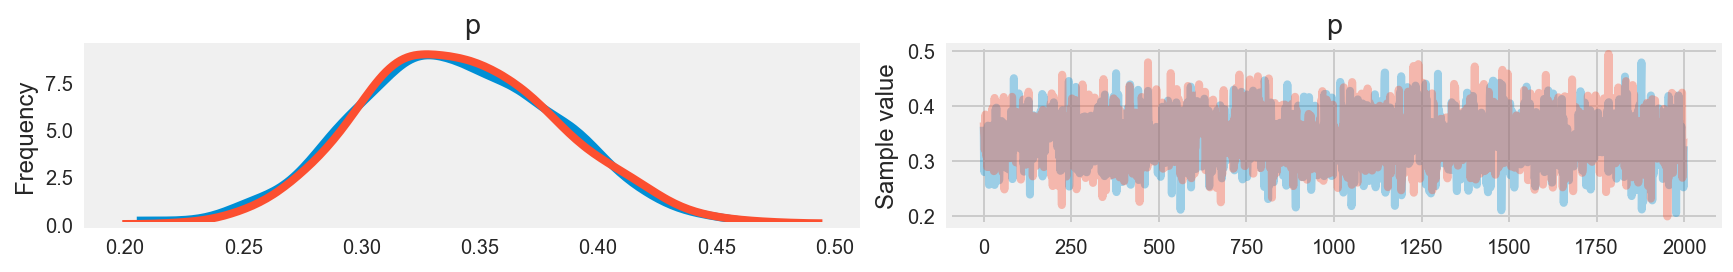

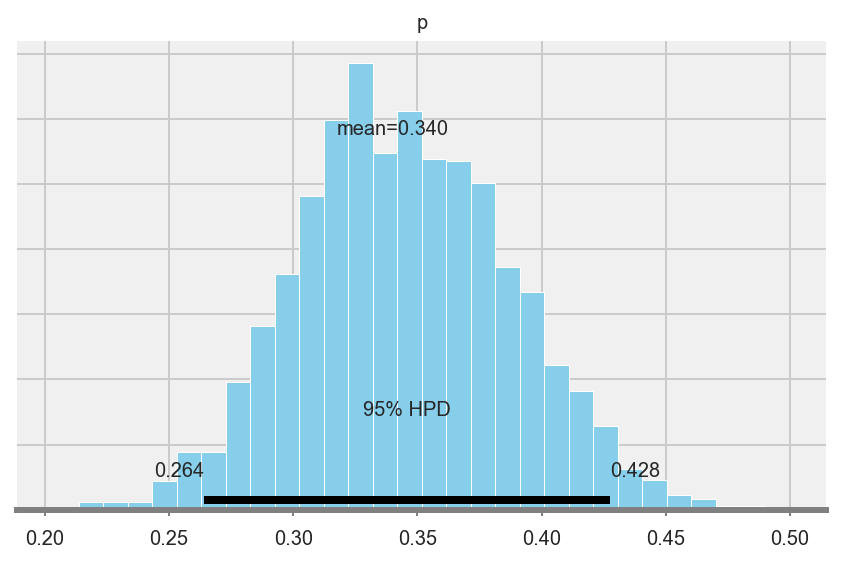

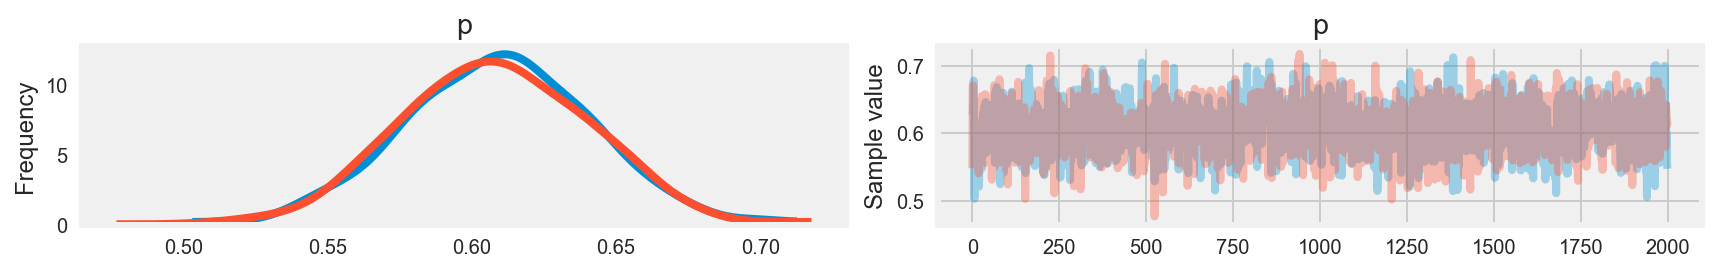

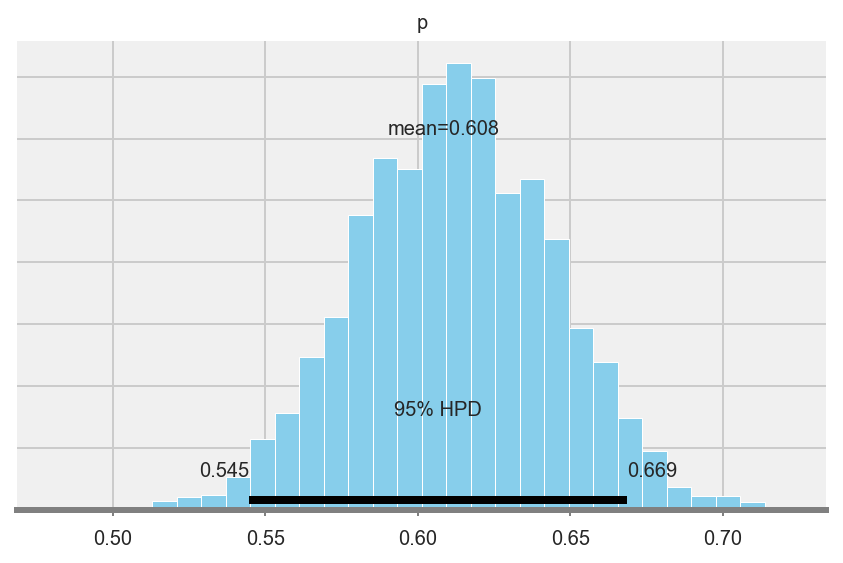

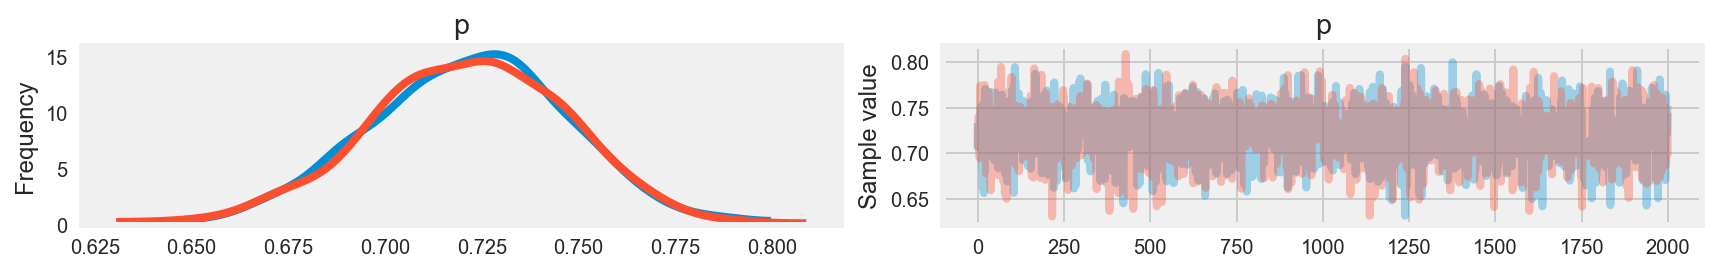

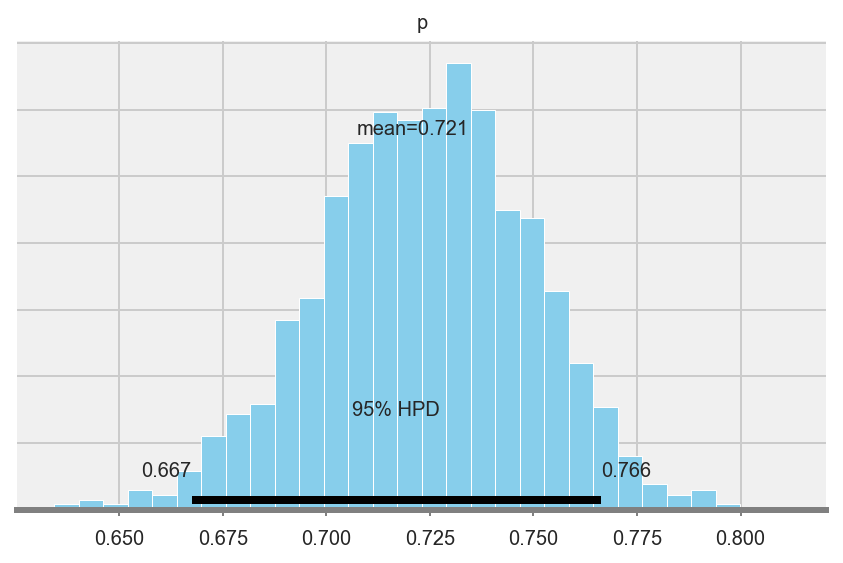

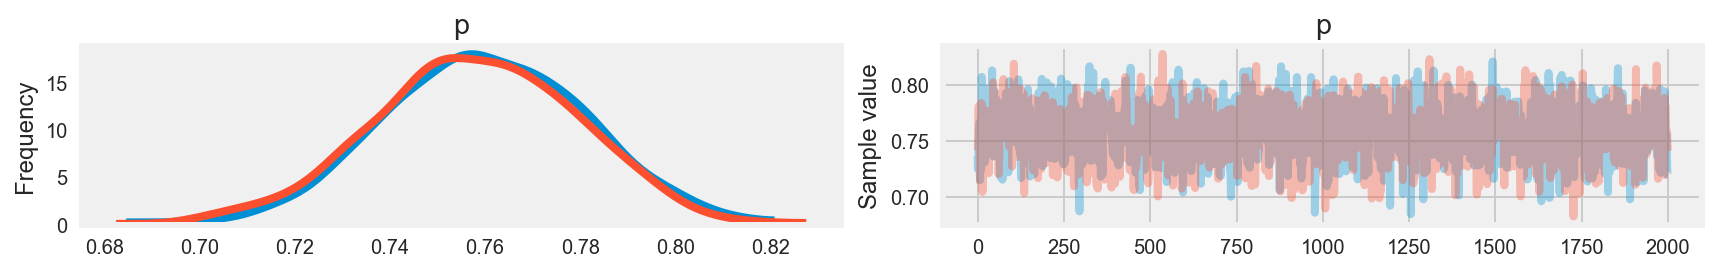

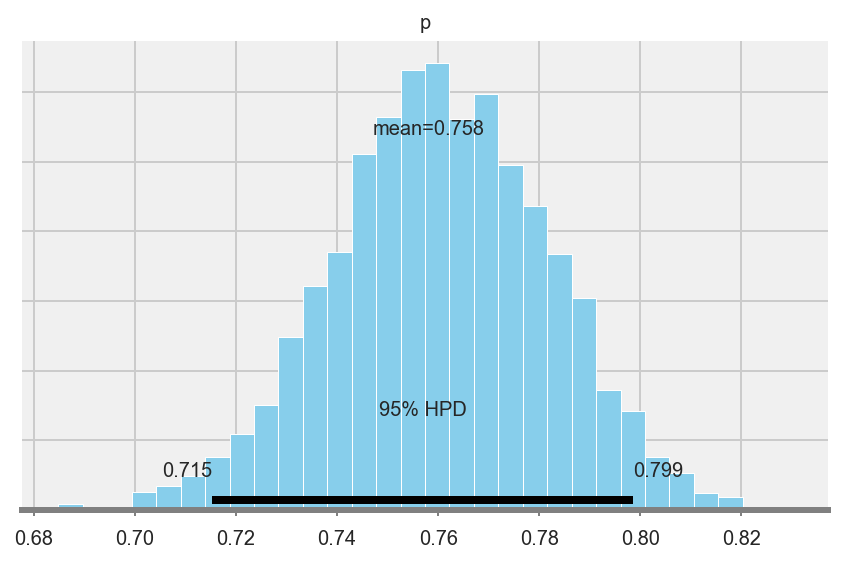

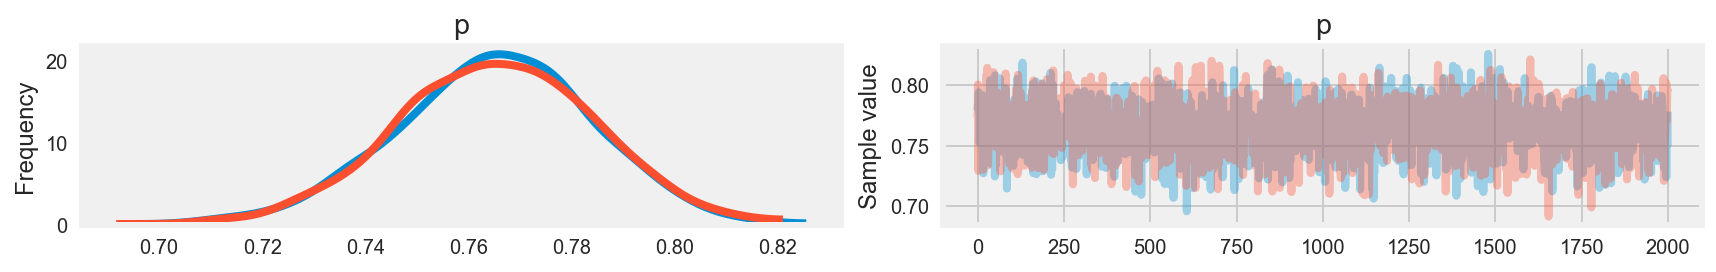

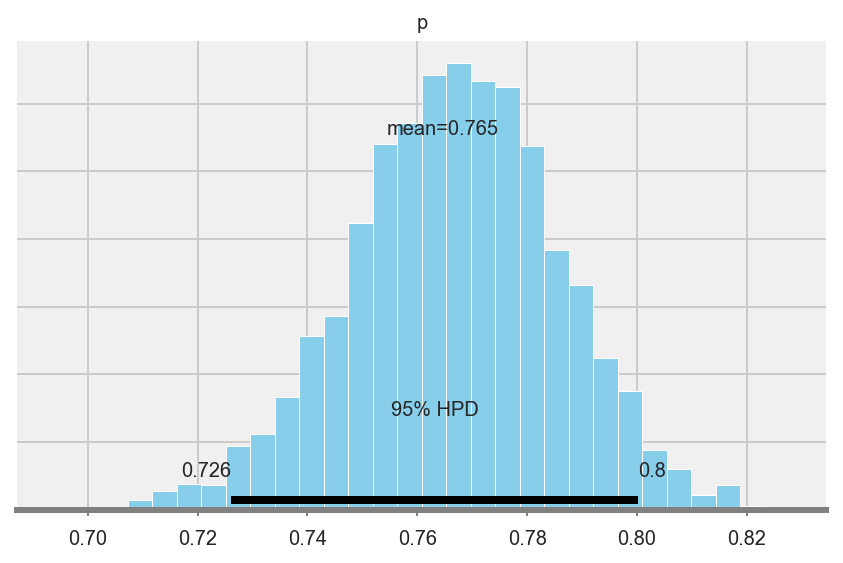

In [51]:
pm_reporting_area1(df)

In [57]:
### Function to build pm_model iterating over period stats
    #want to print out posterior alpha and beta values to iterate as new prior values
    #want to run denoted number of times
def pm_reporting_area2(df, n_success_prior = 15, n_failure_prior = 15):
    alpha_priors = []
    beta_priors = []
    alpha_priors.append(n_success_prior + 1)
    beta_priors.append(n_failure_prior + 1)
    print(alpha_priors, beta_priors)
    
    for i, period in enumerate(df.index):
        #print(i)
        print(period)
        n = df[df.index == period]['Days in Period'].values[0]
        k = df[df.index == period]['Reporting Area2_1'].values[0]
        print(n, k, alpha_priors[i], beta_priors[i])
        
        with pm.Model() as model:
            #Prior
            p = pm.Beta('p', alpha = alpha_priors[i], beta = beta_priors[i])

            #Likelihood
            y = pm.Binomial('y', p = p, n = n, observed = k)

            #Sample from the posterior: NUTS (No U-turn sampling)
                #tune = NUTS-specific parameter
            trace = pm.sample(2000, tune = 1000, njobs = 1)
            pm.traceplot(trace);
            pm.plot_posterior(trace[250:], varnames=['p'], color = '#87ceeb');
            
        alpha_posterior = k + alpha_priors[i]
        beta_posterior = n - k + beta_priors[i]
        alpha_priors.append(alpha_posterior)
        beta_priors.append(beta_posterior)
        #print(alpha_priors, beta_priors)
        
    print(alpha_priors, beta_priors)

[16] [16]
2017Q2
91 14 16 16


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_logodds__]
100%|██████████| 3000/3000 [00:01<00:00, 2266.36it/s]


2017Q3
92 53 30 93


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_logodds__]
100%|██████████| 3000/3000 [00:01<00:00, 2461.36it/s]


2017Q4
92 64 83 132


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_logodds__]
100%|██████████| 3000/3000 [00:01<00:00, 2568.67it/s]


2018Q1
90 70 147 160


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_logodds__]
100%|██████████| 3000/3000 [00:01<00:00, 2863.65it/s]


2018Q2
91 73 217 180


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_logodds__]
100%|██████████| 3000/3000 [00:01<00:00, 2515.65it/s]


[16, 30, 83, 147, 217, 290] [16, 93, 132, 160, 180, 198]


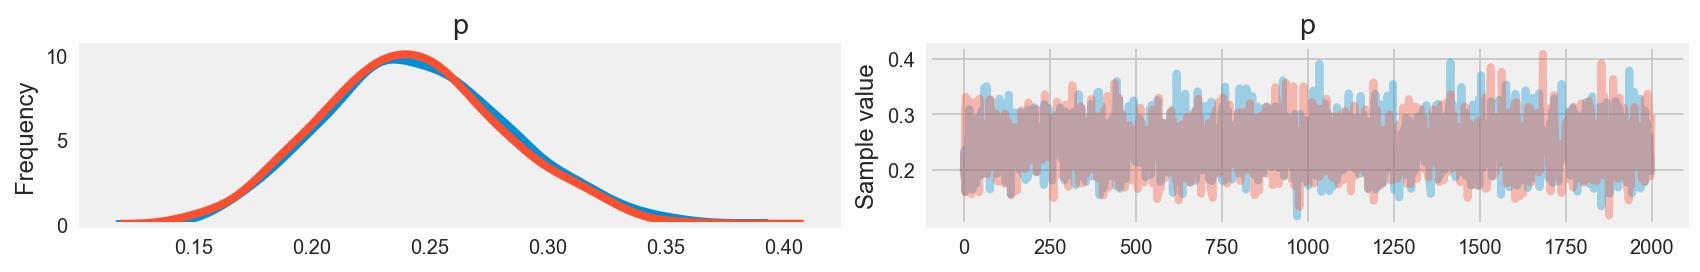

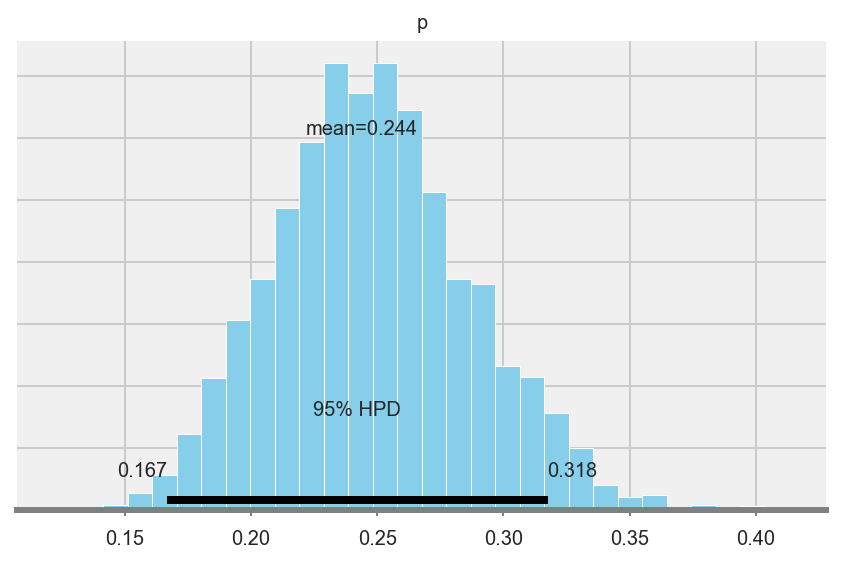

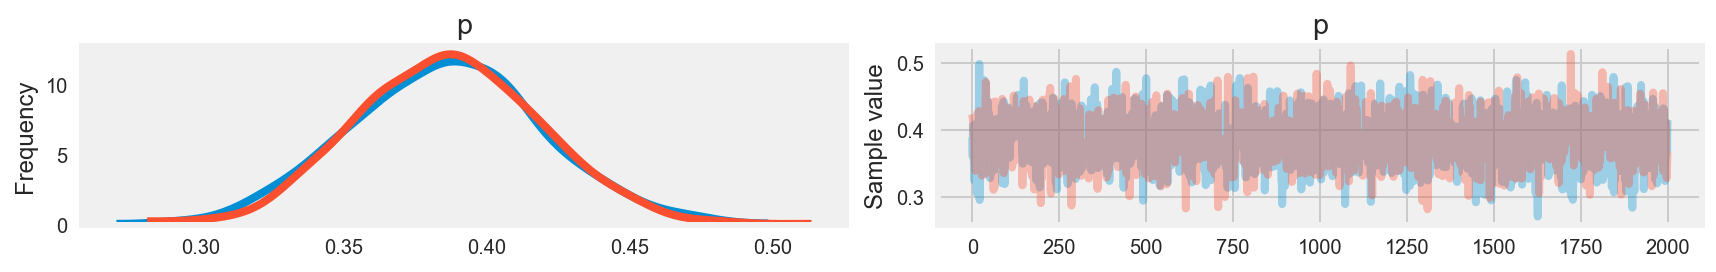

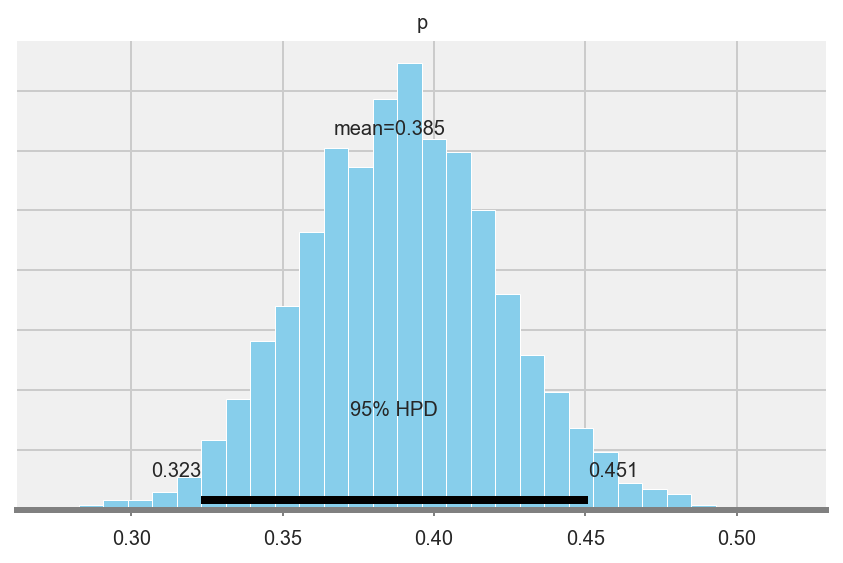

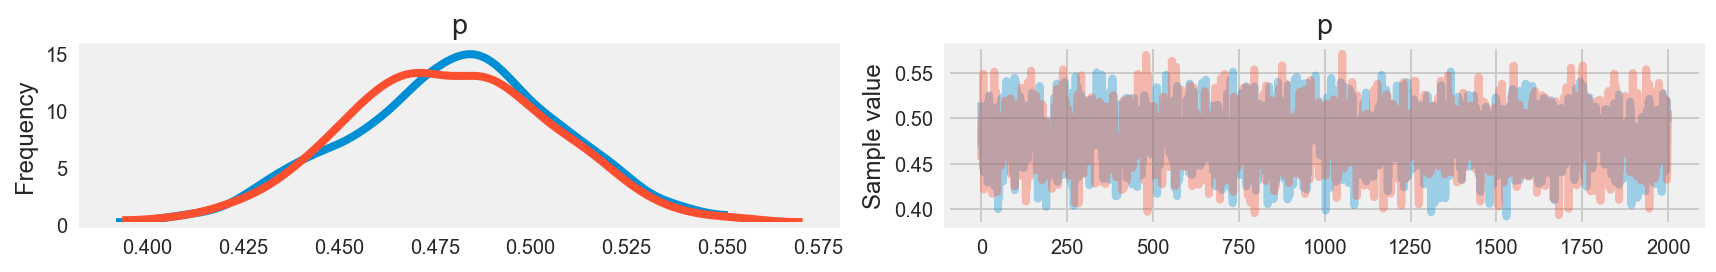

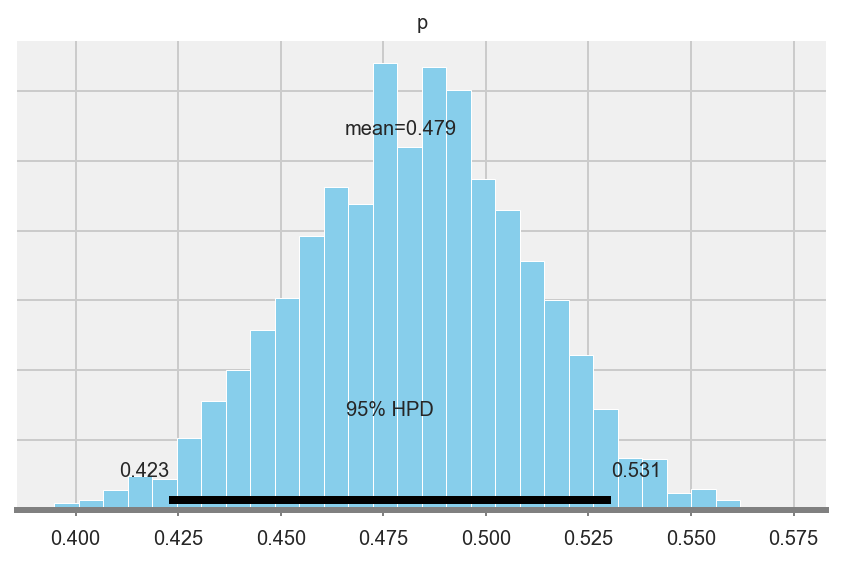

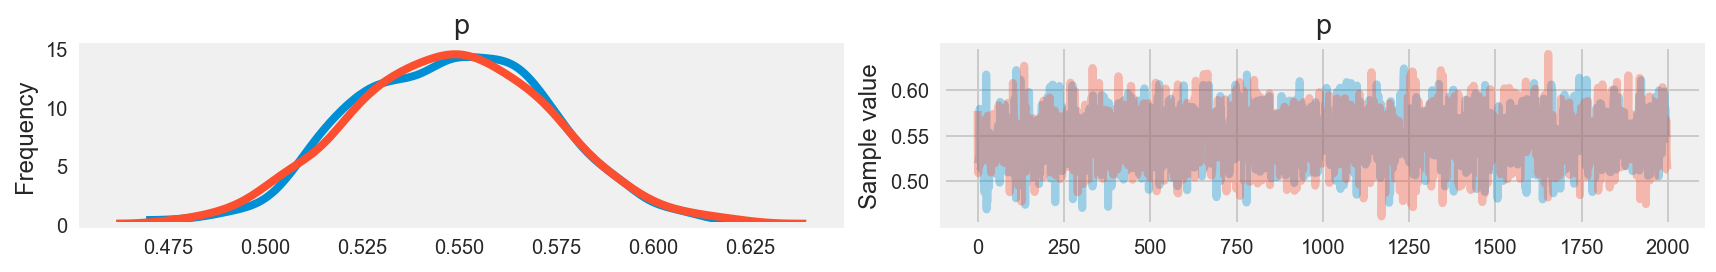

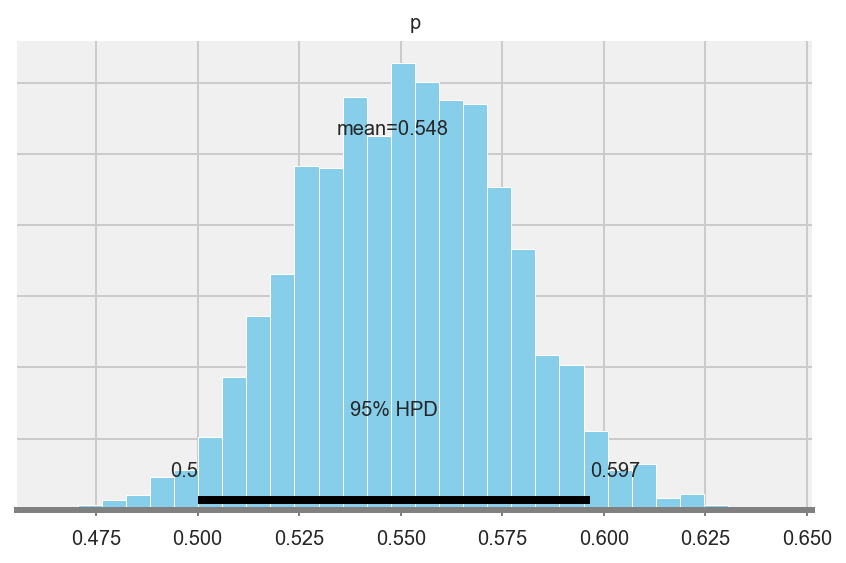

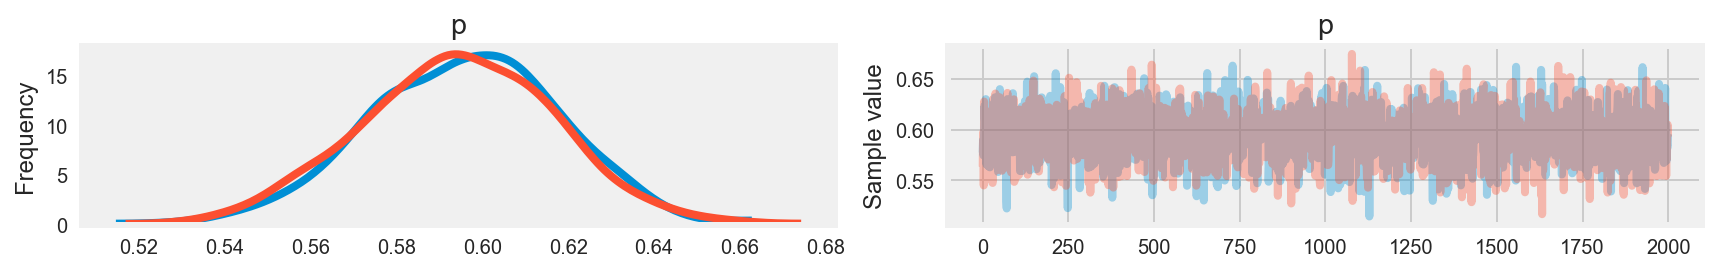

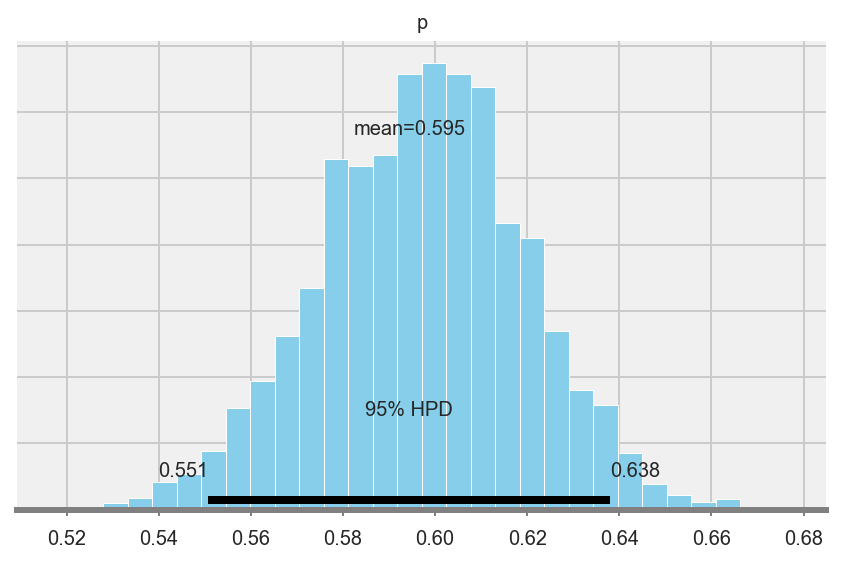

In [54]:
pm_reporting_area2(df)

# Building block 1: Manual plotting

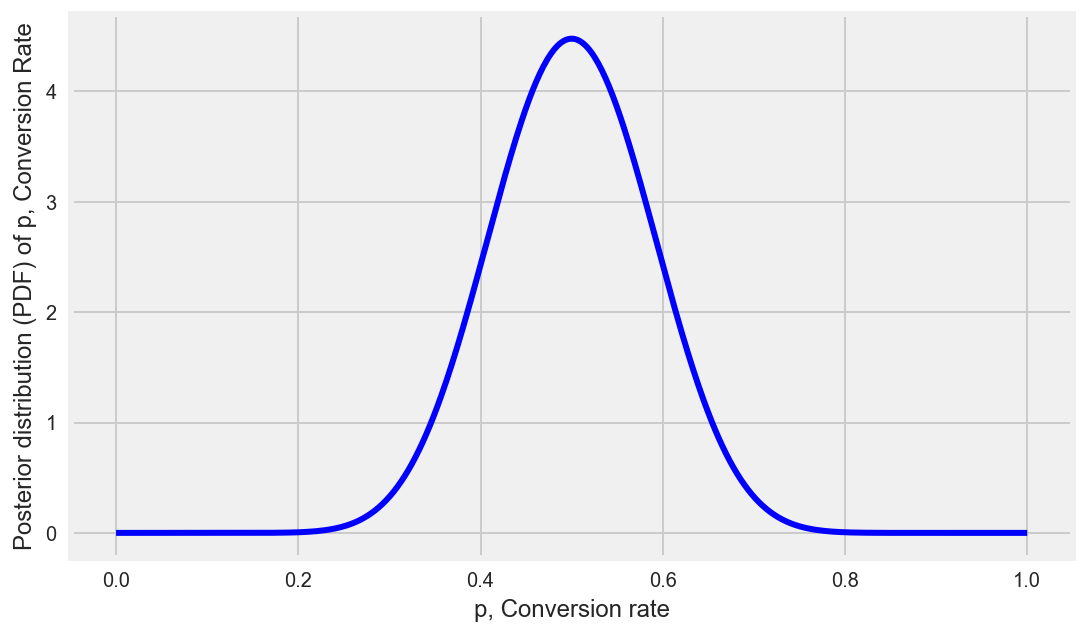

In [12]:
### Example of what we're doing by hand
n_success_prior = 15
n_failure_prior = 15
alpha_prior = n_success_prior + 1
beta_prior = n_failure_prior + 1

pvals = np.linspace(0, 1, 500)    
beta_dist = stats.beta(alpha_prior, beta_prior)

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(pvals, beta_dist.pdf(pvals), 'b', lw=3, label='Posterior')
ax.set_xlabel('p, Conversion rate')
ax.set_ylabel('Posterior distribution (PDF) of p, Conversion Rate')
plt.show()

In [13]:
#Estimate p
n_success_prior = 15
n_failure_prior = 30-15

n = 30
k = 17
mle_p = k/n
mle_p

0.5666666666666667

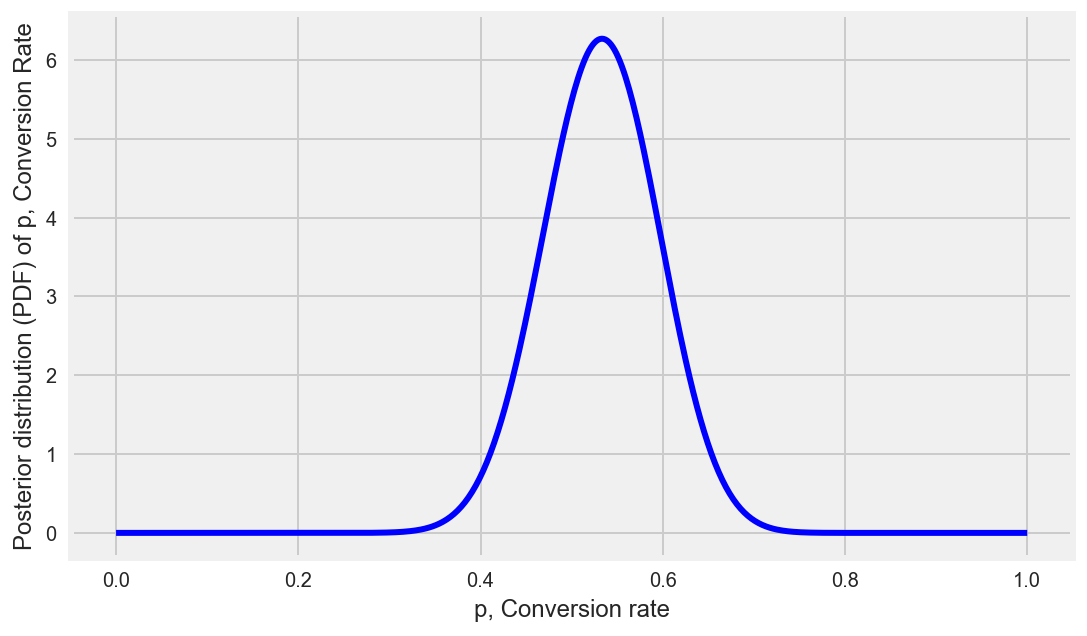

In [14]:
alpha_posterior = k + alpha_prior
beta_posterior = n - k + beta_prior

pvals = np.linspace(0, 1, 500)    
beta_dist = stats.beta(alpha_posterior, beta_posterior)

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(pvals, beta_dist.pdf(pvals), 'b', lw=3, label='Posterior')
ax.set_xlabel('p, Conversion rate')
ax.set_ylabel('Posterior distribution (PDF) of p, Conversion Rate')
plt.show()

# Building block 2: Plotting by period

In [146]:
alpha_prior = n_success_prior + 1
beta_prior = n_failure_prior + 1

with pm.Model() as model:
    #Prior
    p = pm.Beta('p', alpha = alpha_prior, beta = beta_prior)
    
    #Likelihood
    y = pm.Binomial('y', p = p, n = n, observed = k)
    
    #Sample from the posterior: NUTS (No U-turn sampling)
        #tune = NUTS-specific parameter
    trace = pm.sample(2000, tune = 1000, njobs = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_logodds__]
100%|██████████| 3000/3000 [00:01<00:00, 2429.41it/s]


In [151]:
trace[250]
len(trace)

2000

In [155]:
1750/30

58.333333333333336

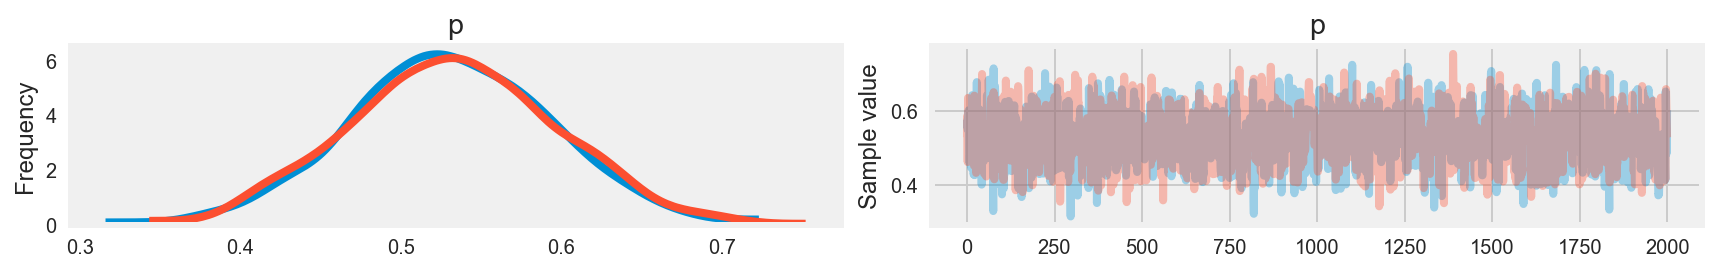

In [163]:
pm.traceplot(trace);

(0, 1)

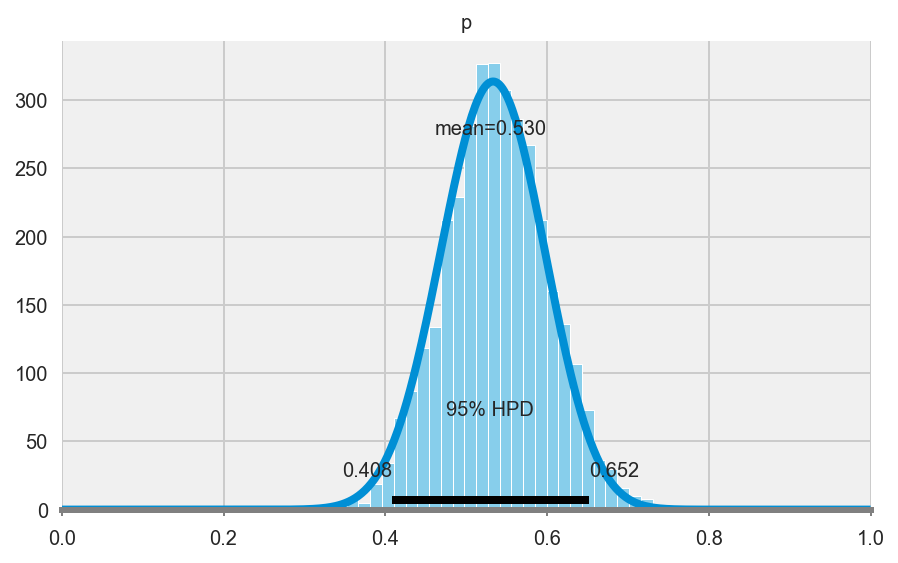

In [160]:
pm.plot_posterior(trace[250:], varnames = ['p'], color = '#87ceeb');
plt.yscale('linear')
plt.plot(pvals, 50*beta_dist.pdf(pvals))
plt.xlim(0, 1)


In [174]:
#using MAP to construct posterior alpha and beta values
alpha_posterior = k + alpha_prior
beta_posterior = n - k + beta_prior

In [177]:
print(alpha_posterior, beta_posterior)
33/(33+29)

33 29


0.532258064516129

June 30 17 16 16


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_logodds__]
100%|██████████| 3000/3000 [00:01<00:00, 2464.68it/s]


33 29


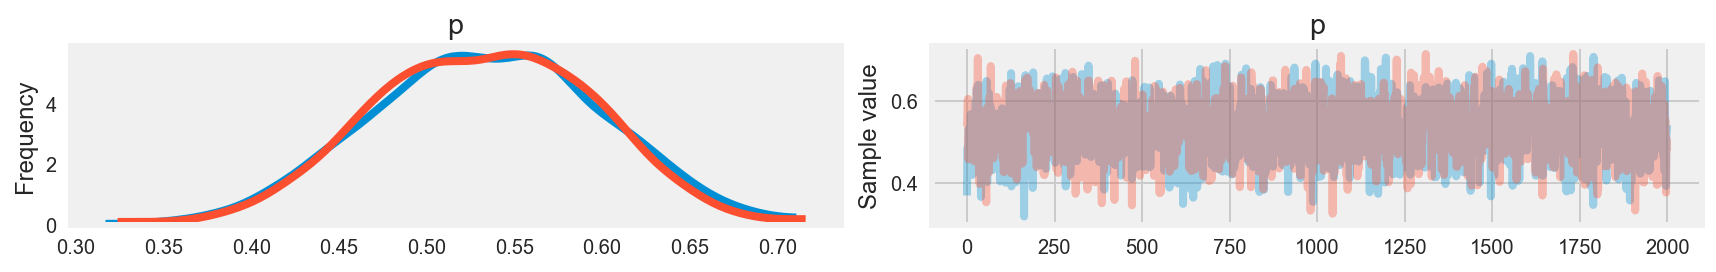

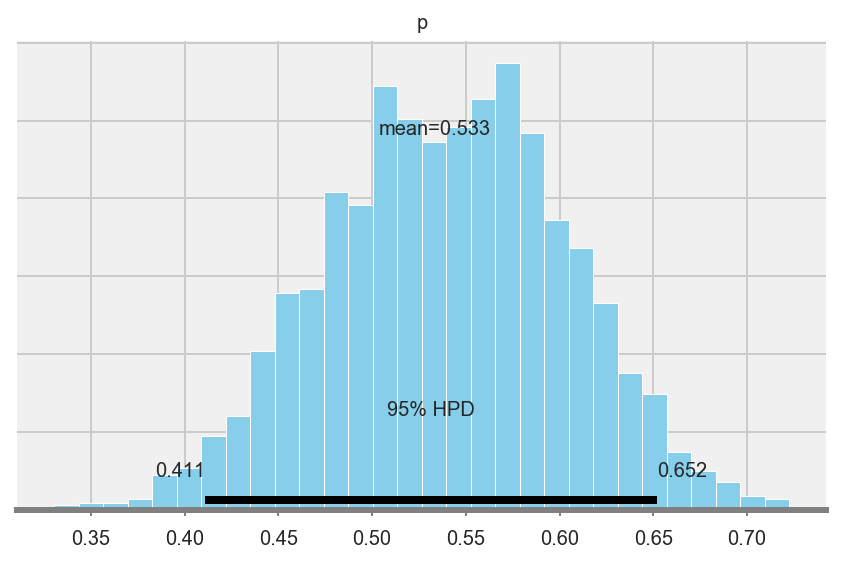

In [181]:
pm_model('June', 30, 17)

July 31 17 16 16


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_logodds__]
100%|██████████| 3000/3000 [00:01<00:00, 2587.01it/s]


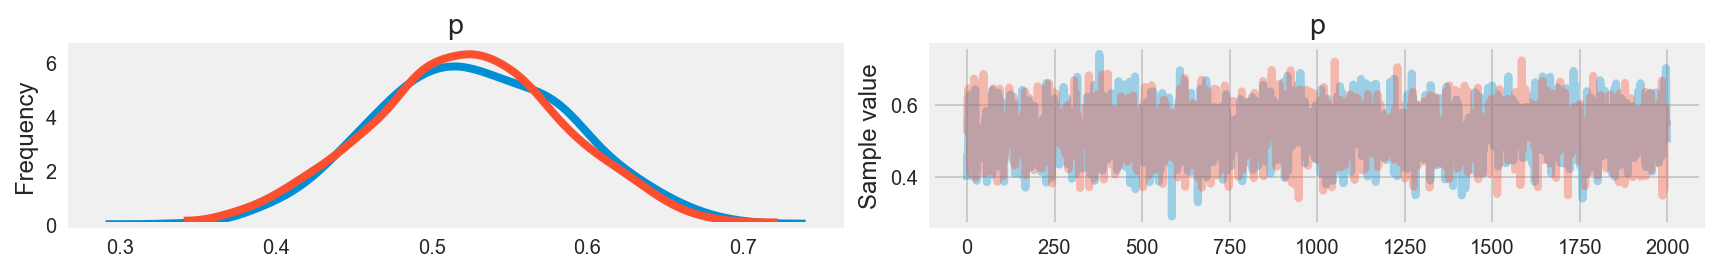

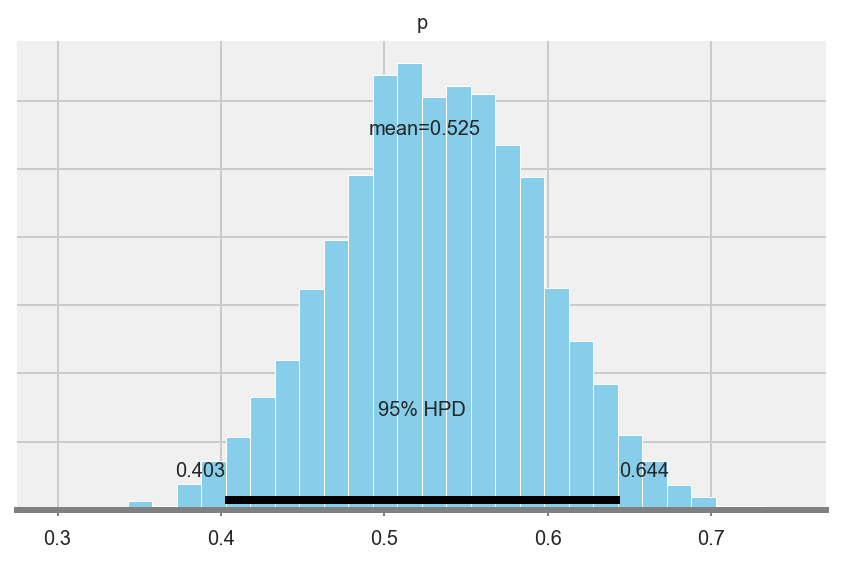

In [172]:
pm_model('July', 31, 17)

August 31 24 16 16


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_logodds__]
100%|██████████| 3000/3000 [00:01<00:00, 2397.37it/s]
The acceptance probability does not match the target. It is 0.8827353310263089, but should be close to 0.8. Try to increase the number of tuning steps.


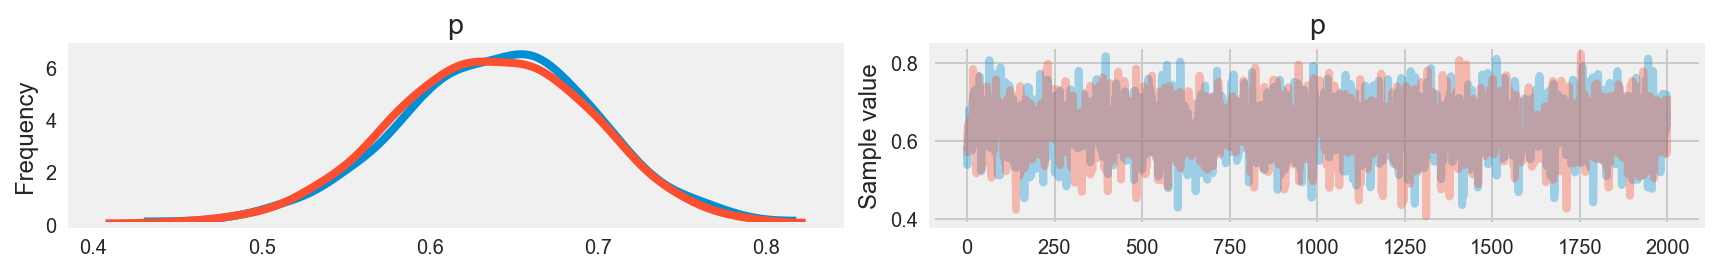

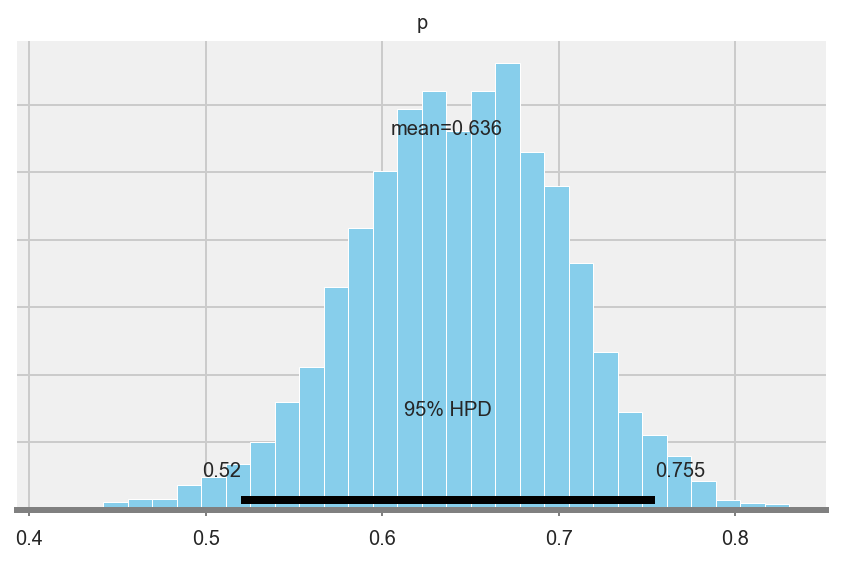

In [173]:
pm_model('August', 31, 24)